In [1]:
#@title Imports and defaults
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import loggamma
from scipy.stats import beta
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)
from tqdm.auto import tqdm

mpl.rcParams["font.size"] = 11
mpl.rcParams["legend.fontsize"] = "Large"

python 3.9.13
matplotlib 3.5.2


## Linear Bandit Environment class

In [2]:

class LinBandit(object):
  """Linear bandit."""

  def __init__(self, X, theta, noise="normal", sigma=0.5):
    self.X = np.copy(X)
    self.K = self.X.shape[0]
    self.d = self.X.shape[1]
    self.theta = np.copy(theta)
    self.noise = noise
    if self.noise == "normal":
      self.sigma = sigma

    self.mu = self.X.dot(self.theta)
    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    if self.noise == "normal":
      self.rt = self.mu + self.sigma * np.random.randn(self.K)
    elif self.noise == "bernoulli":
      self.rt = (np.random.rand(self.K) < self.mu).astype(float)
    elif self.noise == "beta":
      self.rt = np.random.beta(4 * self.mu, 4 * (1 - self.mu))

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    if self.noise == "normal":
      return "Linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)
    elif self.noise == "bernoulli":
      return "Bernoulli linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)
    elif self.noise == "beta":
      return "Beta linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)


In [32]:

def evaluate_one(Alg, params, env, n, period_size=1):
  """One run of a bandit algorithm."""
  alg = Alg(env, n, params)

  regret = np.zeros(n // period_size)
  for t in range(n):
    # generate state
    env.randomize()

    # take action
    arm = alg.get_arm(t)

    # update model and regret
    alg.update(t, arm, env.reward(arm))
    regret_at_t = env.pregret(arm)
    regret[t // period_size] += regret_at_t

  return regret, alg


def evaluate(Alg, params, env, n=1000, period_size=1, printout=True):
  """Multiple runs of a bandit algorithm."""
  if printout:
    print("Evaluating %s" % Alg.print(), end="")
  start = time.time()

  num_exps = len(env)
  regret = np.zeros((n // period_size, num_exps))
  alg = num_exps * [None]

  dots = np.linspace(0, num_exps - 1, 100).astype(int)
  for ex in range(num_exps):
    output = evaluate_one(Alg, params, env[ex], n, period_size)
    regret[:, ex] = output[0]
    alg[ex] = output[1]

    if ex in dots:
      if printout:
        print(".", end="")
  if printout:
    print(" %.1f seconds" % (time.time() - start))

  if printout:
    total_regret = regret.sum(axis=0)
    print("Regret: %.2f +/- %.2f (median: %.2f, max: %.2f, min: %.2f)" %
      (total_regret.mean(), total_regret.std() / np.sqrt(num_exps),
      np.median(total_regret), total_regret.max(), total_regret.min()))

  return regret, alg

## Policy class

In [33]:
class LinBanditAlg:
  def __init__(self, env, n, params):
    self.env = env
    self.X = np.copy(env.X)
    self.K = self.X.shape[0]
    self.d = self.X.shape[1]
    self.n = n
    self.theta0 = np.zeros(self.d)
    self.sigma = 0.5
    self.crs = 1.0 # confidence region scaling

    for attr, val in params.items():
      setattr(self, attr, val)

    # sufficient statistics
    self.Gram = np.eye(self.d)
    self.B = self.Gram.dot(self.theta0)

  def update(self, t, arm, r):
    x = self.X[arm, :]
    self.Gram += np.outer(x, x) / np.square(self.sigma)
    self.B += x * r / np.square(self.sigma)


class LinUCB(LinBanditAlg):
  def __init__(self, env, n, params):
    LinBanditAlg.__init__(self, env, n, params)

    self.cew = self.crs * self.confidence_ellipsoid_width(n)

  def confidence_ellipsoid_width(self, t):
    # Theorem 2 in Abassi-Yadkori (2011)
    # Improved Algorithms for Linear Stochastic Bandits
    delta = 1 / self.n
    L = np.amax(np.linalg.norm(self.X, axis=1))
    Lambda = 1 # to tune
    R = self.sigma
    S = np.sqrt(self.d)
    width = np.sqrt(Lambda) * S + \
      R * np.sqrt(self.d * np.log((1 + t * np.square(L) / Lambda) / delta))
    return width

  def get_arm(self, t):
    Gram_inv = np.linalg.inv(self.Gram)
    theta = Gram_inv.dot(self.B)

    # UCBs
    Gram_inv /= np.square(self.sigma)
    self.mu = self.X.dot(theta) + self.cew * \
      np.sqrt((self.X.dot(Gram_inv) * self.X).sum(axis=1))

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "LinUCB"



## Benchmark

  0%|          | 0/50 [00:00<?, ?it/s]

LinUCB: 43.7 +/- 6.2


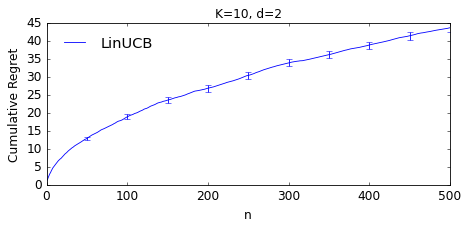

In [39]:
# Gaussian bandit
algs = [
  ("LinUCB", 1, "blue", "-", "LinUCB"),
  ]  

num_runs = 50
n = 500


step = np.arange(1, n  + 1) 
sube = (step.size // 10) * np.arange(1, 11) - 1


# reward noise
sigma = 1
K, d = 10, 2
X = np.random.rand(K, d) - 0.5
X /= np.linalg.norm(X, axis=-1)[:, np.newaxis]
theta = np.random.random(size=(d, )) # frequentist setting : one unique theta

plt.figure(figsize=(6, 3))

alg_num = 0
for alg in algs:
  regret = np.zeros((n, num_runs))
  for run in tqdm(range(num_runs)):

    env = LinBandit(X, theta, sigma=sigma)
      
    alg_class = globals()[alg[0]]
    alg_params = {
      "sigma": sigma,
      }

    task_regret, logs = evaluate(
          alg_class, alg_params, [env], n, printout=False)
    regret[:, run] += task_regret.flatten()


  cum_regret = regret.cumsum(axis=0)
  plt.plot(step, cum_regret.mean(axis=1),
        alg[2], dashes=linestyle2dashes(alg[3]),
        label=alg[4] if alg[1] == 1 else "")
  plt.errorbar(step[sube], cum_regret[sube, :].mean(axis=1),
        cum_regret[sube, :].std(axis=1) / np.sqrt(cum_regret.shape[1]),
        fmt="none", ecolor=alg[2])
  print("%s: %.1f +/- %.1f" % (alg[4],
        cum_regret[-1, :].mean(),
        cum_regret[-1, :].mean() / np.sqrt(cum_regret.shape[1])))

  alg_num += 1

plt.title(f"K={K}, d={d}")
plt.xlabel("n")
plt.ylabel("Cumulative Regret")
#plt.axvline(x=n, ls='--', color='red', alpha=0.5)
plt.ylim(bottom=0)
plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
#plt.savefig('results/toy_example_action_set.pdf')